In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from scipy import signal

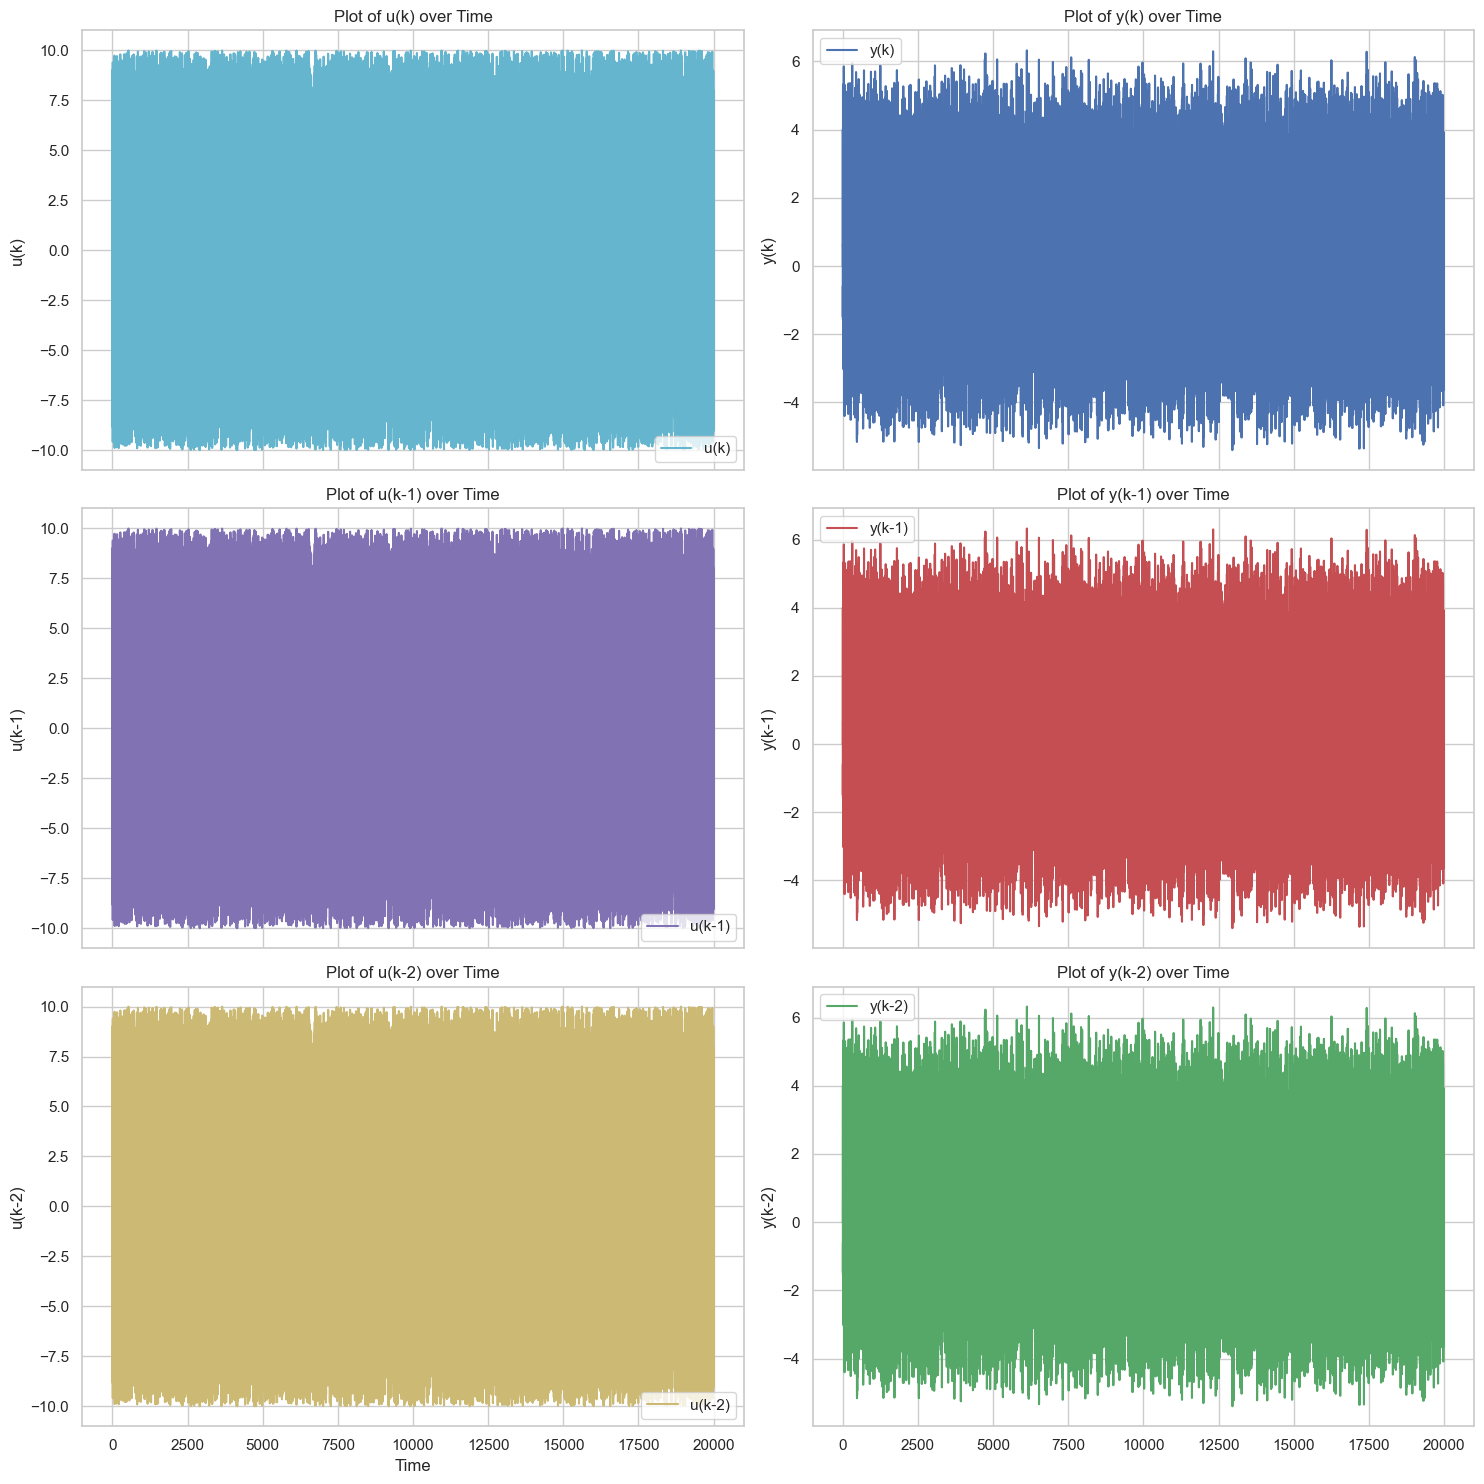

In [2]:
# Set a random seed for reproducibility
np.random.seed(42)

# Define the number of samples
k_max = 20000
t = np.linspace(0, k_max, k_max)  # Time variable

# Generate random inputs
u = 2 * np.random.uniform(-5, 5, k_max)

# Initialize y(k) array
y = np.zeros(k_max)

# Define y(k) calculations
for k in range(1, k_max):
    y[k] = 1 / (1 + (y[k-1])**2) + 0.25 * u[k] - 0.3 * u[k-1]

# Shift arrays for y(k-1), y(k-2), u(k-1), u(k-2)
y_k_1 = np.zeros(k_max)
y_k_2 = np.zeros(k_max)
u_k_1 = np.zeros(k_max)
u_k_2 = np.zeros(k_max)

y_k_1[1:] = y[:-1]
y_k_2[2:] = y[:-2]
u_k_1[1:] = u[:-1]
u_k_2[2:] = u[:-2]

# Set up Seaborn style
sns.set_theme(style="whitegrid")

# Create a single figure with a 3x2 grid of subplots
fig, ax = plt.subplots(3, 2, figsize=(15, 15), sharex=True)

# Plot u(k) over time
ax[0, 0].plot(t, u, label='u(k)', color='c')
ax[0, 0].set_ylabel('u(k)')
ax[0, 0].set_title('Plot of u(k) over Time')
ax[0, 0].legend()
ax[0, 0].grid(True)

# Plot y(k) over time
ax[0, 1].plot(t, y, label='y(k)', color='b')
ax[0, 1].set_ylabel('y(k)')
ax[0, 1].set_title('Plot of y(k) over Time')
ax[0, 1].legend()
ax[0, 1].grid(True)

# Plot u(k-1) over time
ax[1, 0].plot(t, u_k_1, label='u(k-1)', color='m')
ax[1, 0].set_ylabel('u(k-1)')
ax[1, 0].set_title('Plot of u(k-1) over Time')
ax[1, 0].legend()
ax[1, 0].grid(True)

# Plot y(k-1) over time
ax[1, 1].plot(t, y_k_1, label='y(k-1)', color='r')
ax[1, 1].set_ylabel('y(k-1)')
ax[1, 1].set_title('Plot of y(k-1) over Time')
ax[1, 1].legend()
ax[1, 1].grid(True)

# Plot u(k-2) over time
ax[2, 0].plot(t, u_k_2, label='u(k-2)', color='y')
ax[2, 0].set_xlabel('Time')
ax[2, 0].set_ylabel('u(k-2)')
ax[2, 0].set_title('Plot of u(k-2) over Time')
ax[2, 0].legend()
ax[2, 0].grid(True)

# Plot y(k-2) over time
ax[2, 1].plot(t, y_k_2, label='y(k-2)', color='g')
ax[2, 1].set_ylabel('y(k-2)')
ax[2, 1].set_title('Plot of y(k-2) over Time')
ax[2, 1].legend()
ax[2, 1].grid(True)

# Show the combined plot
plt.tight_layout()
plt.show()

In [3]:
X = np.array([y_k_1, y_k_2, u, u_k_1, u_k_2]).T
y = y.reshape(-1, 1)
u = u.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(y)
y_norm = scaler.transform(y.reshape(-1, 1))
y_k_1_norm = scaler.transform(y_k_1.reshape(-1, 1))
y_k_2_norm = scaler.transform(y_k_2.reshape(-1, 1)) 

scaler.fit(u)
u_norm = scaler.transform(u.reshape(-1, 1))
u_k_1_norm = scaler.transform(u_k_1.reshape(-1, 1))
u_k_2_norm = scaler.transform(u_k_2.reshape(-1, 1)) 

In [4]:
X_norm = np.array([y_k_1_norm.flatten(), y_k_2_norm.flatten(), u_norm.flatten(), u_k_1_norm.flatten(), u_k_2_norm.flatten()]).T

# Assuming X and y are your feature matrix and target vector respectively
train_size = int(0.8 * len(X))  # 80% of the data

# First 80% of the data for training
X_train = X[:train_size]
y_train = y[:train_size]

# Last 20% of the data for validation
X_val = X[train_size:]
y_val = y[train_size:]

# For the normalized data
X_train_norm = X_norm[:train_size]
y_train_norm = y_norm[:train_size]
X_val_norm = X_norm[train_size:]
y_val_norm = y_norm[train_size:]

In [5]:
class MLP:
    def __init__(self, layers, activations, optimizer='adam', learning_rate=0.001, l2_lambda=0.01):
        self.layers = layers
        self.activations = activations
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda  # Regularization parameter
        self.weights, self.biases = self.initialize_weights()
        self.optimizer = optimizer
        self.momentum_w, self.momentum_b = None, None
        self.v_w, self.v_b = None, None
        self.initialize_optimizer_parameters()
        # Arrays to store training and validation loss/accuracy
        self.training_losses = []
        self.validation_losses = []
        self.training_accuracies = []
        self.validation_accuracies = []

    def initialize_weights(self):
        weights = []
        biases = []
        for i in range(len(self.layers) - 1):
            input_dim = self.layers[i]
            output_dim = self.layers[i + 1]
            
            # Nguyen-Widrow initialization
            # Step 1: Randomly initialize weights from a uniform distribution
            w = np.random.uniform(-1, 1, (input_dim, output_dim))
            
            # Step 2: Compute the scaling factor `beta`
            beta = 0.7 * output_dim ** (1.0 / input_dim)
            
            # Step 3: Normalize the weights to have unit length for each column
            norm = np.linalg.norm(w, axis=0)
            w = beta * (w / norm)
            
            # Initialize biases to zero
            b = np.zeros((1, output_dim))
            
            weights.append(w)
            biases.append(b)
        
        return weights, biases

    def initialize_optimizer_parameters(self):
        if self.optimizer in ['adam', 'rmsprop']:
            self.momentum_w = [np.zeros_like(w) for w in self.weights]
            self.momentum_b = [np.zeros_like(b) for b in self.biases]
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.v_b = [np.zeros_like(b) for b in self.biases]

        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def activation(self, x, func):
        if func == 'tanh':
            return np.tanh(x)
        elif func == 'linear':
            return x

    def activation_derivative(self, x, func):
        if func == 'tanh':
            return 1 - np.tanh(x) ** 2
        elif func == 'linear':
            return np.ones_like(x)

    def forward(self, x):
        self.z_list = []
        self.a_list = [x]

        for i in range(len(self.weights)):
            z = np.dot(x, self.weights[i]) + self.biases[i]
            x = self.activation(z, self.activations[i])
            self.z_list.append(z)
            self.a_list.append(x)
        return x

    def backward(self, y_true, y_pred):
        gradients_w = []
        gradients_b = []
        loss_derivative = 2 * (y_pred - y_true) / y_true.shape[0]

        # Output layer
        delta = loss_derivative * self.activation_derivative(self.z_list[-1], self.activations[-1])
        grad_w = np.dot(self.a_list[-2].T, delta) + self.l2_lambda * self.weights[-1]
        grad_b = np.sum(delta, axis=0, keepdims=True)

        gradients_w.insert(0, grad_w)
        gradients_b.insert(0, grad_b)

        # Hidden layers
        for i in range(len(self.layers) - 3, -1, -1):
            delta = np.dot(delta, self.weights[i + 1].T) * self.activation_derivative(self.z_list[i], self.activations[i])
            grad_w = np.dot(self.a_list[i].T, delta) + self.l2_lambda * self.weights[i]
            grad_b = np.sum(delta, axis=0, keepdims=True)
            gradients_w.insert(0, grad_w)
            gradients_b.insert(0, grad_b)

        return gradients_w, gradients_b

    def update_weights(self, gradients_w, gradients_b):
        if self.optimizer == 'gradient_descent':
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * gradients_w[i]
                self.biases[i] -= self.learning_rate * gradients_b[i]
        elif self.optimizer == 'sgd':
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * gradients_w[i]
                self.biases[i] -= self.learning_rate * gradients_b[i]
        elif self.optimizer == 'rmsprop':
            for i in range(len(self.weights)):
                self.momentum_w[i] = self.beta2 * self.momentum_w[i] + (1 - self.beta2) * gradients_w[i]**2
                self.momentum_b[i] = self.beta2 * self.momentum_b[i] + (1 - self.beta2) * gradients_b[i]**2

                self.weights[i] -= self.learning_rate * gradients_w[i] / (np.sqrt(self.momentum_w[i]) + self.epsilon)
                self.biases[i] -= self.learning_rate * gradients_b[i] / (np.sqrt(self.momentum_b[i]) + self.epsilon)
        elif self.optimizer == 'adam':
            for i in range(len(self.weights)):
                self.momentum_w[i] = self.beta1 * self.momentum_w[i] + (1 - self.beta1) * gradients_w[i]
                self.momentum_b[i] = self.beta1 * self.momentum_b[i] + (1 - self.beta1) * gradients_b[i]

                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * gradients_w[i]**2
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * gradients_b[i]**2

                m_w_corrected = self.momentum_w[i] / (1 - self.beta1)
                m_b_corrected = self.momentum_b[i] / (1 - self.beta1)
                v_w_corrected = self.v_w[i] / (1 - self.beta2)
                v_b_corrected = self.v_b[i] / (1 - self.beta2)

                self.weights[i] -= self.learning_rate * m_w_corrected / (np.sqrt(v_w_corrected) + self.epsilon)
                self.biases[i] -= self.learning_rate * m_b_corrected / (np.sqrt(v_b_corrected) + self.epsilon)

    def calculate_loss(self, y_true, y_pred):
        return np.mean((y_pred - y_true) ** 2) + (self.l2_lambda / 2) * sum([np.sum(w ** 2) for w in self.weights])

    def calculate_accuracy(self, y_true, y_pred):
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2_score = 1 - (ss_res / ss_tot)
        return r2_score

    def train(self, x_train, y_train, x_val=None, y_val=None, epochs=100):
        for epoch in range(epochs):
            # Training phase
            y_pred_train = self.forward(x_train)
            gradients_w, gradients_b = self.backward(y_train, y_pred_train)
            self.update_weights(gradients_w, gradients_b)

            # Calculate training loss and accuracy
            train_loss = self.calculate_loss(y_train, y_pred_train)
            train_acc = self.calculate_accuracy(y_train, y_pred_train)
            self.training_losses.append(train_loss)
            self.training_accuracies.append(train_acc)

            # Validation phase (if validation data provided)
            if x_val is not None and y_val is not None:
                y_pred_val = self.forward(x_val)
                val_loss = self.calculate_loss(y_val, y_pred_val)
                val_acc = self.calculate_accuracy(y_val, y_pred_val)
                self.validation_losses.append(val_loss)
                self.validation_accuracies.append(val_acc)

                print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            else:
                print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    def predict(self, x):
        return self.forward(x)
    
    def get_weights(self):
        return self.weights

    def get_biases(self):
        return self.biases

    def set_weights(self, weights):
        self.weights = weights

    def set_biases(self, biases):
        self.biases = biases

In [6]:
nn = MLP(layers=[X.shape[-1], 128, 1], activations=['tanh', 'linear'], optimizer='adam', learning_rate=0.05, l2_lambda=0.0001)

In [7]:
nn.train(X_train, y_train, x_val=X_val, y_val=y_val, epochs=1000)

Epoch 1/1000 - Train Loss: 5.1986, Train Acc: 0.0236, Val Loss: 1.0218, Val Acc: 0.8044
Epoch 2/1000 - Train Loss: 0.9462, Train Acc: 0.8257, Val Loss: 4.8163, Val Acc: 0.0619
Epoch 3/1000 - Train Loss: 4.7231, Train Acc: 0.1134, Val Loss: 1.8130, Val Acc: 0.6497
Epoch 4/1000 - Train Loss: 1.7333, Train Acc: 0.6774, Val Loss: 0.8503, Val Acc: 0.8381
Epoch 5/1000 - Train Loss: 0.8784, Train Acc: 0.8388, Val Loss: 2.6356, Val Acc: 0.4889
Epoch 6/1000 - Train Loss: 2.6857, Train Acc: 0.4980, Val Loss: 1.8896, Val Acc: 0.6350
Epoch 7/1000 - Train Loss: 1.9147, Train Acc: 0.6435, Val Loss: 0.6646, Val Acc: 0.8748
Epoch 8/1000 - Train Loss: 0.6604, Train Acc: 0.8802, Val Loss: 0.7876, Val Acc: 0.8509
Epoch 9/1000 - Train Loss: 0.7561, Train Acc: 0.8623, Val Loss: 1.4946, Val Acc: 0.7126
Epoch 10/1000 - Train Loss: 1.4527, Train Acc: 0.7310, Val Loss: 1.3335, Val Acc: 0.7443
Epoch 11/1000 - Train Loss: 1.2921, Train Acc: 0.7614, Val Loss: 0.6669, Val Acc: 0.8748
Epoch 12/1000 - Train Loss: 0.

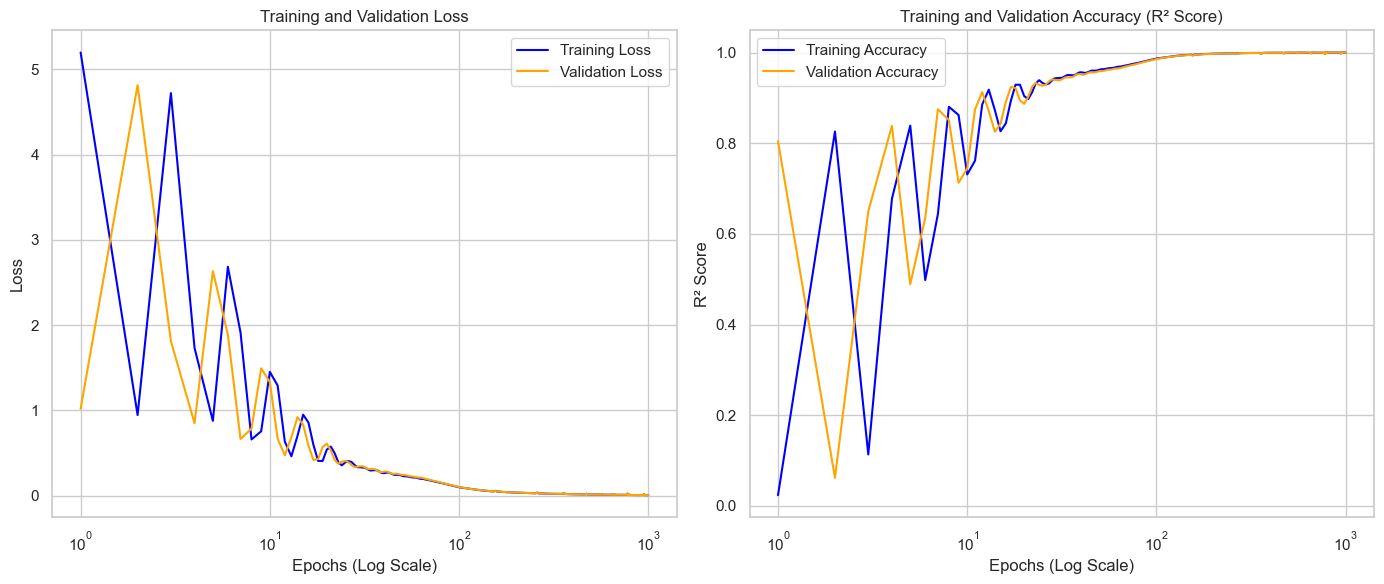

In [8]:
training_losses = nn.training_losses
validation_losses = nn.validation_losses
training_accuracies = nn.training_accuracies
validation_accuracies = nn.validation_accuracies

# Create a figure with 1 row and 2 columns for loss and accuracy plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Create a range of epochs for the x-axis
epochs = range(1, len(training_losses) + 1)

# Plot Loss with Logarithmic X-Axis
sns.lineplot(x=epochs, y=training_losses, ax=ax[0], label='Training Loss', color='blue')
sns.lineplot(x=epochs, y=validation_losses, ax=ax[0], label='Validation Loss', color='orange')
ax[0].set_xscale('log')  # Set x-axis to logarithmic scale
ax[0].set_xlabel('Epochs (Log Scale)')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()

# Plot Accuracy with Logarithmic X-Axis
sns.lineplot(x=epochs, y=training_accuracies, ax=ax[1], label='Training Accuracy', color='blue')
sns.lineplot(x=epochs, y=validation_accuracies, ax=ax[1], label='Validation Accuracy', color='orange')
ax[1].set_xscale('log')  # Set x-axis to logarithmic scale
ax[1].set_xlabel('Epochs (Log Scale)')
ax[1].set_ylabel('R² Score')
ax[1].set_title('Training and Validation Accuracy (R² Score)')
ax[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [9]:
# y_pred_train_norm = nn.predict(X_train_norm)
# y_pred_val_norm = nn.predict(X_val_norm)
# y_pred_train = scaler.inverse_transform(y_pred_train_norm)
# y_pred_val = scaler.inverse_transform(y_pred_val_norm)

y_pred_train_norm = nn.predict(X_train)
y_pred_val_norm = nn.predict(X_val)
y_pred_train = y_pred_train_norm
y_pred_val = y_pred_val_norm

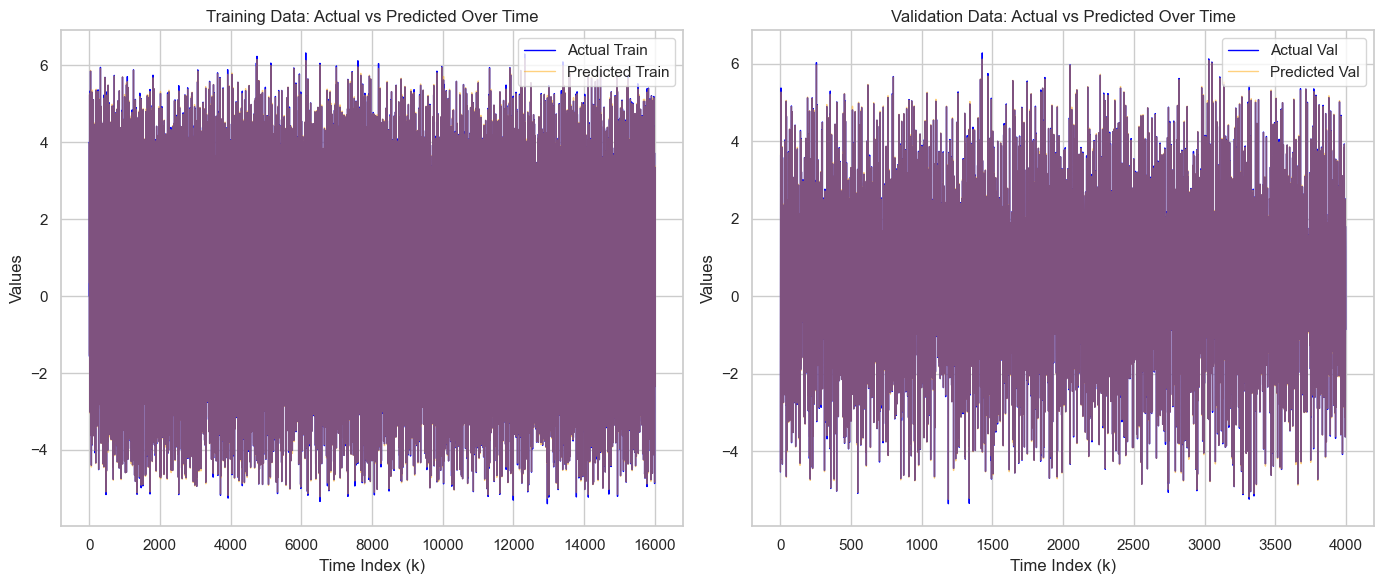

In [10]:
# Assuming y_train, y_pred_train, y_val, and y_pred_val are already defined
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Generate time indices for training and validation
train_indices = range(len(y_train))
val_indices = range(len(y_val))

# Plot y_pred_train and y_train over time (k) with reduced alpha for predicted line
sns.lineplot(x=train_indices, y=y_train.flatten(), ax=ax[0], color='blue', label='Actual Train', linewidth=1)
sns.lineplot(x=train_indices, y=y_pred_train.flatten(), ax=ax[0], color='orange', label='Predicted Train', alpha=0.5, linewidth=1)
ax[0].set_xlabel('Time Index (k)')
ax[0].set_ylabel('Values')
ax[0].set_title('Training Data: Actual vs Predicted Over Time')
ax[0].legend()

# Plot y_pred_val and y_val over time (k) with reduced alpha for predicted line
sns.lineplot(x=val_indices, y=y_val.flatten(), ax=ax[1], color='blue', label='Actual Val', linewidth=1)
sns.lineplot(x=val_indices, y=y_pred_val.flatten(), ax=ax[1], color='orange', label='Predicted Val', alpha=0.5, linewidth=1)
ax[1].set_xlabel('Time Index (k)')
ax[1].set_ylabel('Values')
ax[1].set_title('Validation Data: Actual vs Predicted Over Time')
ax[1].legend()

# Show the updated plots
plt.tight_layout()
plt.show()

In [11]:
weights = nn.get_weights()
biases = nn.get_biases()

In [12]:
class MLPVectoral:
    def __init__(self, layers, activations, optimizer='adam', learning_rate=0.001, l2_lambda=0.01, weights=None, biases=None):
        self.layers = layers
        self.activations = activations
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda  # Regularization parameter
        self.weights = weights if weights else self.initialize_weights()[0]
        self.biases = biases if biases else self.initialize_weights()[1]
        self.optimizer = optimizer
        self.momentum_w, self.momentum_b = None, None
        self.v_w, self.v_b = None, None
        self.initialize_optimizer_parameters()
        # Arrays to store training and validation loss/accuracy
        self.training_losses = []
        self.validation_losses = []
        self.training_accuracies = []
        self.validation_accuracies = []

    def initialize_weights(self):
        weights = []
        biases = []
        for i in range(len(self.layers) - 1):
            input_dim = self.layers[i]
            output_dim = self.layers[i + 1]
            
            # Nguyen-Widrow initialization
            w = np.random.uniform(-1, 1, (input_dim, output_dim))
            beta = 0.7 * output_dim ** (1.0 / input_dim)
            norm = np.linalg.norm(w, axis=0)
            w = beta * (w / norm)
            
            b = np.zeros((1, output_dim))
            weights.append(w)
            biases.append(b)
        
        return weights, biases

    def initialize_optimizer_parameters(self):
        if self.optimizer in ['adam', 'rmsprop']:
            self.momentum_w = [np.zeros_like(w) for w in self.weights]
            self.momentum_b = [np.zeros_like(b) for b in self.biases]
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.v_b = [np.zeros_like(b) for b in self.biases]

        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def activation(self, x, func):
        if func == 'tanh':
            return np.tanh(x)
        elif func == 'linear':
            return x

    def activation_derivative(self, x, func):
        if func == 'tanh':
            return 1 - np.tanh(x) ** 2
        elif func == 'linear':
            return np.ones_like(x)

    def forward(self, x):
        self.z_list = []
        self.a_list = [x]

        for i in range(len(self.weights)):
            z = np.dot(x, self.weights[i]) + self.biases[i]
            x = self.activation(z, self.activations[i])
            self.z_list.append(z)
            self.a_list.append(x)
        return x

    def backward(self, y_true, y_pred):
        gradients_w = []
        gradients_b = []
        loss_derivative = 2 * (y_pred - y_true)

        # Output layer
        delta = loss_derivative * self.activation_derivative(self.z_list[-1], self.activations[-1])
        grad_w = np.dot(self.a_list[-2].T, delta) + self.l2_lambda * self.weights[-1]
        grad_b = np.sum(delta, axis=0, keepdims=True)

        gradients_w.insert(0, grad_w)
        gradients_b.insert(0, grad_b)

        # Hidden layers
        for i in range(len(self.layers) - 3, -1, -1):
            delta = np.dot(delta, self.weights[i + 1].T) * self.activation_derivative(self.z_list[i], self.activations[i])
            grad_w = np.dot(self.a_list[i].T, delta) + self.l2_lambda * self.weights[i]
            grad_b = np.sum(delta, axis=0, keepdims=True)
            gradients_w.insert(0, grad_w)
            gradients_b.insert(0, grad_b)

        return gradients_w, gradients_b

    def update_weights(self, gradients_w, gradients_b):
        if self.optimizer == 'gradient_descent' or self.optimizer == 'sgd':
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * gradients_w[i]
                self.biases[i] -= self.learning_rate * gradients_b[i]
        elif self.optimizer == 'rmsprop':
            for i in range(len(self.weights)):
                self.momentum_w[i] = self.beta2 * self.momentum_w[i] + (1 - self.beta2) * gradients_w[i]**2
                self.momentum_b[i] = self.beta2 * self.momentum_b[i] + (1 - self.beta2) * gradients_b[i]**2

                self.weights[i] -= self.learning_rate * gradients_w[i] / (np.sqrt(self.momentum_w[i]) + self.epsilon)
                self.biases[i] -= self.learning_rate * gradients_b[i] / (np.sqrt(self.momentum_b[i]) + self.epsilon)
        elif self.optimizer == 'adam':
            for i in range(len(self.weights)):
                self.momentum_w[i] = self.beta1 * self.momentum_w[i] + (1 - self.beta1) * gradients_w[i]
                self.momentum_b[i] = self.beta1 * self.momentum_b[i] + (1 - self.beta1) * gradients_b[i]

                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * gradients_w[i]**2
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * gradients_b[i]**2

                m_w_corrected = self.momentum_w[i] / (1 - self.beta1)
                m_b_corrected = self.momentum_b[i] / (1 - self.beta1)
                v_w_corrected = self.v_w[i] / (1 - self.beta2)
                v_b_corrected = self.v_b[i] / (1 - self.beta2)

                self.weights[i] -= self.learning_rate * m_w_corrected / (np.sqrt(v_w_corrected) + self.epsilon)
                self.biases[i] -= self.learning_rate * m_b_corrected / (np.sqrt(v_b_corrected) + self.epsilon)

    def calculate_loss(self, y_true, y_pred):
        return np.mean((y_pred - y_true) ** 2) + (self.l2_lambda / 2) * sum([np.sum(w ** 2) for w in self.weights])

    def calculate_accuracy(self, y_true, y_pred):
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2_score = 1 - (ss_res / ss_tot)
        return r2_score

    def train(self, x_train, y_train, x_val=None, y_val=None, epochs=100):
        for epoch in range(epochs):
            # Training with feedback
            y_train_pred_prev = 0  # Initial value for y(k-2)
            y_pred_train = 0  # Initial value for y(k-1)
            
            for k in range(len(x_train)):
                # Prepare the input data with feedback
                if k == 0:
                    x_train[k][0] = y_pred_train  # Initial value for y_train(k-1)
                    x_train[k][1] = y_train_pred_prev  # Initial value for y_train(k-2)
                elif k == 1:
                    x_train[k][0] = y_pred_train  # Use y(k-1) from k=0
                    x_train[k][1] = y_train_pred_prev  # Keep the initial y(k-2)
                else:
                    x_train[k][0] = y_pred_train  # Feedback y_pred_train(k-1) as y_train(k-1)
                    x_train[k][1] = y_train_pred_prev  # Feedback y_pred_train(k-2)

                # Forward pass and backpropagation
                y_pred_train = self.forward(x_train[k].reshape(1, -1))
                gradients_w, gradients_b = self.backward(y_train[k], y_pred_train)
                self.update_weights(gradients_w, gradients_b)

                # Store y_train_pred for feedback at next step
                y_train_pred_prev = y_pred_train[0]

            # After epoch: Evaluate on training set for metrics
            y_pred_epoch_train = []
            y_train_pred_prev = 0  # Reset feedback state for epoch evaluation
            y_pred_train = 0
            
            for k in range(len(x_train)):
                # Use feedback during epoch evaluation
                if k == 0:
                    x_train[k][0] = y_pred_train  # Initial value for y(k-1)
                    x_train[k][1] = y_train_pred_prev  # Initial value for y(k-2)
                elif k == 1:
                    x_train[k][0] = y_pred_train
                    x_train[k][1] = y_train_pred_prev
                else:
                    x_train[k][0] = y_pred_epoch_train[-1]  # Feedback from previous predictions
                    x_train[k][1] = y_train_pred_prev

                y_pred_epoch_train.append(self.forward(x_train[k].reshape(1, -1))[0])
                y_train_pred_prev = y_pred_epoch_train[-1]

            # Calculate training metrics
            y_pred_epoch_train = np.array(y_pred_epoch_train)
            train_loss = self.calculate_loss(y_train, y_pred_epoch_train)
            train_acc = self.calculate_accuracy(y_train, y_pred_epoch_train)
            self.training_losses.append(train_loss)
            self.training_accuracies.append(train_acc)

            # Validation with feedback
            if x_val is not None and y_val is not None:
                y_pred_epoch_val = []
                y_val_pred_prev = 0  # Initial value for validation feedback
                y_pred_val = 0
                
                for k in range(len(x_val)):
                    if k == 0:
                        x_val[k][0] = y_pred_val  # Initial value for y_val(k-1)
                        x_val[k][1] = y_val_pred_prev  # Initial value for y_val(k-2)
                    elif k == 1:
                        x_val[k][0] = y_pred_val
                        x_val[k][1] = y_val_pred_prev
                    else:
                        x_val[k][0] = y_pred_epoch_val[-1]
                        x_val[k][1] = y_val_pred_prev

                    y_pred_epoch_val.append(self.forward(x_val[k].reshape(1, -1))[0])
                    y_val_pred_prev = y_pred_epoch_val[-1]

                # Calculate validation metrics
                y_pred_epoch_val = np.array(y_pred_epoch_val)
                val_loss = self.calculate_loss(y_val, y_pred_epoch_val)
                val_acc = self.calculate_accuracy(y_val, y_pred_epoch_val)
                self.validation_losses.append(val_loss)
                self.validation_accuracies.append(val_acc)

                # Print metrics
                print(f"Epoch {epoch + 1}/{epochs} - "
                      f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            else:
                # Print metrics without validation
                print(f"Epoch {epoch + 1}/{epochs} - "
                      f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    def predict(self, x):
        y_pred = []
        y_pred_prev = 0
        for k in range(len(x)):
            if k > 0:
                x[k][0] = y_pred[-1]  # Feedback from the last prediction
                x[k][1] = y_pred_prev
            current_pred = self.forward(x[k].reshape(1, -1))[0]
            y_pred.append(current_pred)
            y_pred_prev = current_pred
        return np.array(y_pred)
    
    def get_weights(self):
        return self.weights

    def get_biases(self):
        return self.biases

    def set_weights(self, weights):
        self.weights = weights

    def set_biases(self, biases):
        self.biases = biases

In [13]:
nnv = MLPVectoral(layers=[X.shape[-1], 128, 1], activations=['tanh', 'linear'], optimizer='adam', learning_rate=0.01, l2_lambda=0.0001, weights=weights, biases=biases)

In [14]:
nnv.train(X_train, y_train, x_val=X_val, y_val=y_val, epochs=50)

C:\Users\Acer\AppData\Local\Temp\ipykernel_13240\1528841553.py:144: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_train[k][0] = y_pred_train  # Use y(k-1) from k=0
C:\Users\Acer\AppData\Local\Temp\ipykernel_13240\1528841553.py:145: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_train[k][1] = y_train_pred_prev  # Keep the initial y(k-2)
C:\Users\Acer\AppData\Local\Temp\ipykernel_13240\1528841553.py:147: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_train[k][0] 

Epoch 1/50 - Train Loss: 0.0310, Train Acc: 0.9945, Val Loss: 0.0288, Val Acc: 0.9948
Epoch 2/50 - Train Loss: 0.0245, Train Acc: 0.9956, Val Loss: 0.0242, Val Acc: 0.9955
Epoch 3/50 - Train Loss: 0.0232, Train Acc: 0.9958, Val Loss: 0.0224, Val Acc: 0.9958
Epoch 4/50 - Train Loss: 0.0108, Train Acc: 0.9981, Val Loss: 0.0105, Val Acc: 0.9981
Epoch 5/50 - Train Loss: 0.0101, Train Acc: 0.9983, Val Loss: 0.0105, Val Acc: 0.9981
Epoch 6/50 - Train Loss: 0.0078, Train Acc: 0.9987, Val Loss: 0.0078, Val Acc: 0.9986
Epoch 7/50 - Train Loss: 0.0185, Train Acc: 0.9967, Val Loss: 0.0190, Val Acc: 0.9965
Epoch 8/50 - Train Loss: 0.0114, Train Acc: 0.9980, Val Loss: 0.0111, Val Acc: 0.9980
Epoch 9/50 - Train Loss: 0.0089, Train Acc: 0.9985, Val Loss: 0.0087, Val Acc: 0.9985
Epoch 10/50 - Train Loss: 0.0055, Train Acc: 0.9991, Val Loss: 0.0058, Val Acc: 0.9991
Epoch 11/50 - Train Loss: 0.0349, Train Acc: 0.9936, Val Loss: 0.0351, Val Acc: 0.9933
Epoch 12/50 - Train Loss: 0.0138, Train Acc: 0.9976,

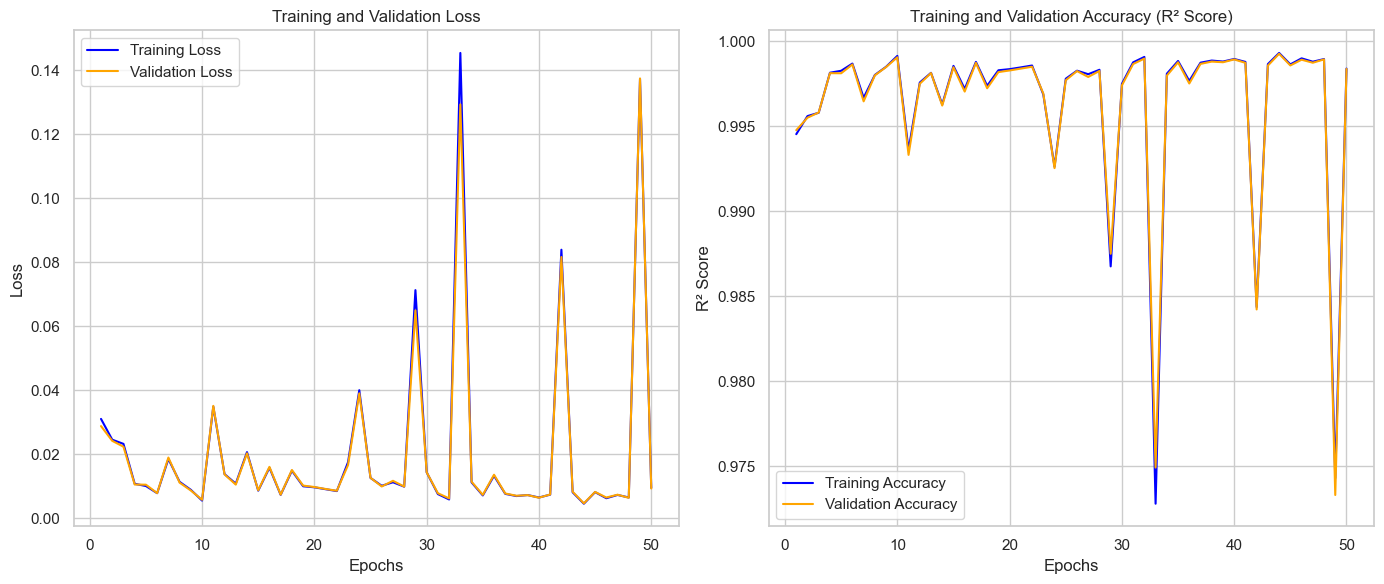

In [15]:
training_losses = nnv.training_losses
validation_losses = nnv.validation_losses
training_accuracies = nnv.training_accuracies
validation_accuracies = nnv.validation_accuracies

# Create a figure with 1 row and 2 columns for loss and accuracy plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Create a range of epochs for the x-axis
epochs = range(1, len(training_losses) + 1)

# Plot Loss with Logarithmic X-Axis
sns.lineplot(x=epochs, y=training_losses, ax=ax[0], label='Training Loss', color='blue')
sns.lineplot(x=epochs, y=validation_losses, ax=ax[0], label='Validation Loss', color='orange')
# ax[0].set_xscale('log')  # Set x-axis to logarithmic scale
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()

# Plot Accuracy with Logarithmic X-Axis
sns.lineplot(x=epochs, y=training_accuracies, ax=ax[1], label='Training Accuracy', color='blue')
sns.lineplot(x=epochs, y=validation_accuracies, ax=ax[1], label='Validation Accuracy', color='orange')
# ax[1].set_xscale('log')  # Set x-axis to logarithmic scale
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('R² Score')
ax[1].set_title('Training and Validation Accuracy (R² Score)')
ax[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

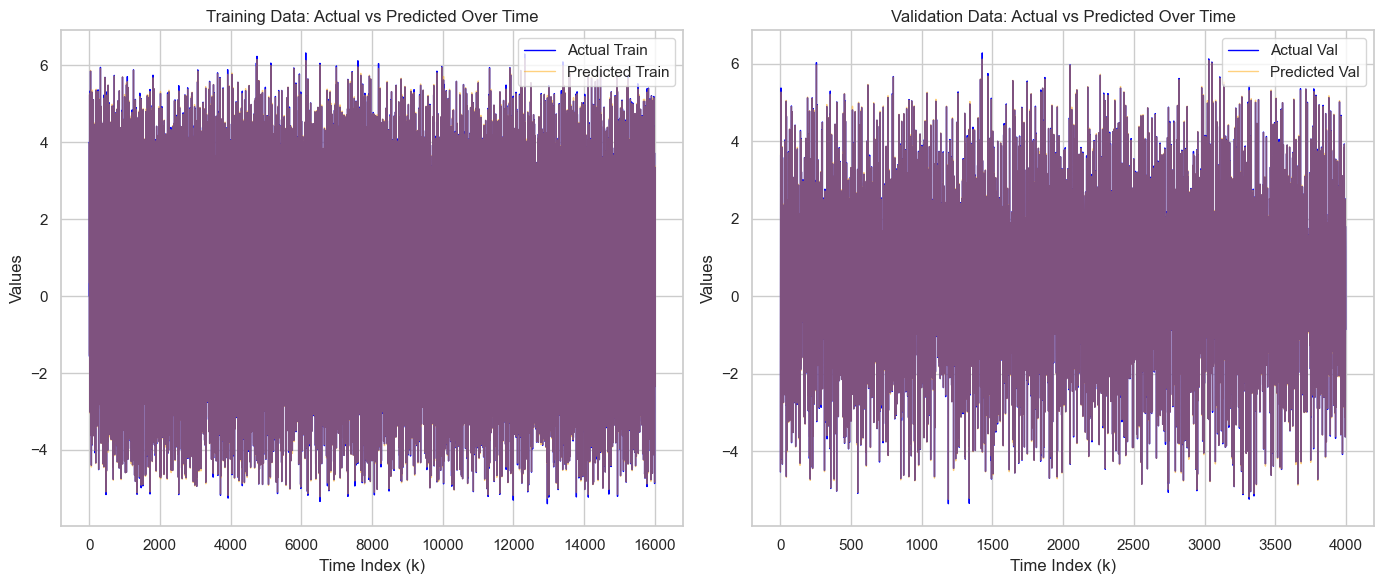

In [16]:
# Assuming y_train, y_pred_train, y_val, and y_pred_val are already defined
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Generate time indices for training and validation
train_indices = range(len(y_train))
val_indices = range(len(y_val))

# Plot y_pred_train and y_train over time (k) with reduced alpha for predicted line
sns.lineplot(x=train_indices, y=y_train.flatten(), ax=ax[0], color='blue', label='Actual Train', linewidth=1)
sns.lineplot(x=train_indices, y=y_pred_train.flatten(), ax=ax[0], color='orange', label='Predicted Train', alpha=0.5, linewidth=1)
ax[0].set_xlabel('Time Index (k)')
ax[0].set_ylabel('Values')
ax[0].set_title('Training Data: Actual vs Predicted Over Time')
ax[0].legend()

# Plot y_pred_val and y_val over time (k) with reduced alpha for predicted line
sns.lineplot(x=val_indices, y=y_val.flatten(), ax=ax[1], color='blue', label='Actual Val', linewidth=1)
sns.lineplot(x=val_indices, y=y_pred_val.flatten(), ax=ax[1], color='orange', label='Predicted Val', alpha=0.5, linewidth=1)
ax[1].set_xlabel('Time Index (k)')
ax[1].set_ylabel('Values')
ax[1].set_title('Validation Data: Actual vs Predicted Over Time')
ax[1].legend()

# Show the updated plots
plt.tight_layout()
plt.show()

In [17]:
t_test = np.linspace(0, k_max, k_max)  # Time variable (consistent across inputs)

# Generate sinusoidal input for u_test_sin(k)
frequency = 5    # Frequency of the sine wave
amplitude = 10   # Amplitude of the sine wave
phase = 0        # Phase shift of the sine wave
u_test_sin = amplitude * np.sin(2 * np.pi * frequency * t_test + phase)

# Initialize y_test_sin(k) array and calculate values based on the given formula
y_test_sin = np.zeros(k_max)
for k in range(1, k_max):
    y_test_sin[k] = 1 / (1 + (y_test_sin[k-1])**2) + 0.25 * u_test_sin[k] - 0.3 * u_test_sin[k-1]

# Shift arrays for y_test_sin(k-1), y_test_sin(k-2), u_test_sin(k-1), u_test_sin(k-2)
y_k_1_test_sin = np.zeros(k_max)
y_k_2_test_sin = np.zeros(k_max)
u_k_1_test_sin = np.zeros(k_max)
u_k_2_test_sin = np.zeros(k_max)

y_k_1_test_sin[1:] = y_test_sin[:-1]
y_k_2_test_sin[2:] = y_test_sin[:-2]
u_k_1_test_sin[1:] = u_test_sin[:-1]
u_k_2_test_sin[2:] = u_test_sin[:-2]

# Initialize MinMaxScaler to scale between -1 and 1
scaler_y = MinMaxScaler(feature_range=(-1, 1))
scaler_u = MinMaxScaler(feature_range=(-1, 1))

# Fit the scalers on training data (assuming y and u are defined)
scaler_y.fit(y.reshape(-1, 1))  # Fit on y
scaler_u.fit(u.reshape(-1, 1))  # Fit on u

# Normalize the testing data using the fitted scalers
y_test_sin_norm = scaler_y.transform(y_test_sin.reshape(-1, 1)).flatten()
y_k_1_test_sin_norm = scaler_y.transform(y_k_1_test_sin.reshape(-1, 1)).flatten()
y_k_2_test_sin_norm = scaler_y.transform(y_k_2_test_sin.reshape(-1, 1)).flatten()

u_test_sin_norm = scaler_u.transform(u_test_sin.reshape(-1, 1)).flatten()
u_k_1_test_sin_norm = scaler_u.transform(u_k_1_test_sin.reshape(-1, 1)).flatten()
u_k_2_test_sin_norm = scaler_u.transform(u_k_2_test_sin.reshape(-1, 1)).flatten()

# Prepare input matrices for the models
X_test_sin_norm = np.array([y_k_1_test_sin_norm, y_k_2_test_sin_norm, u_test_sin_norm, u_k_1_test_sin_norm, u_k_2_test_sin_norm]).T
X_test_sin = np.array([y_k_1_test_sin, y_k_2_test_sin, u_test_sin, u_k_1_test_sin, u_k_2_test_sin]).T

# Make predictions using the models
y_pred_test_sin_t2 = nnv.predict(X_test_sin).flatten()  # Predictions from model nnv
y_pred_test_sin_t1 = nn.predict(X_test_sin).flatten()   # Predictions from model nn

C:\Users\Acer\AppData\Local\Temp\ipykernel_13240\1528841553.py:226: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[k][0] = y_pred[-1]  # Feedback from the last prediction
C:\Users\Acer\AppData\Local\Temp\ipykernel_13240\1528841553.py:227: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[k][1] = y_pred_prev


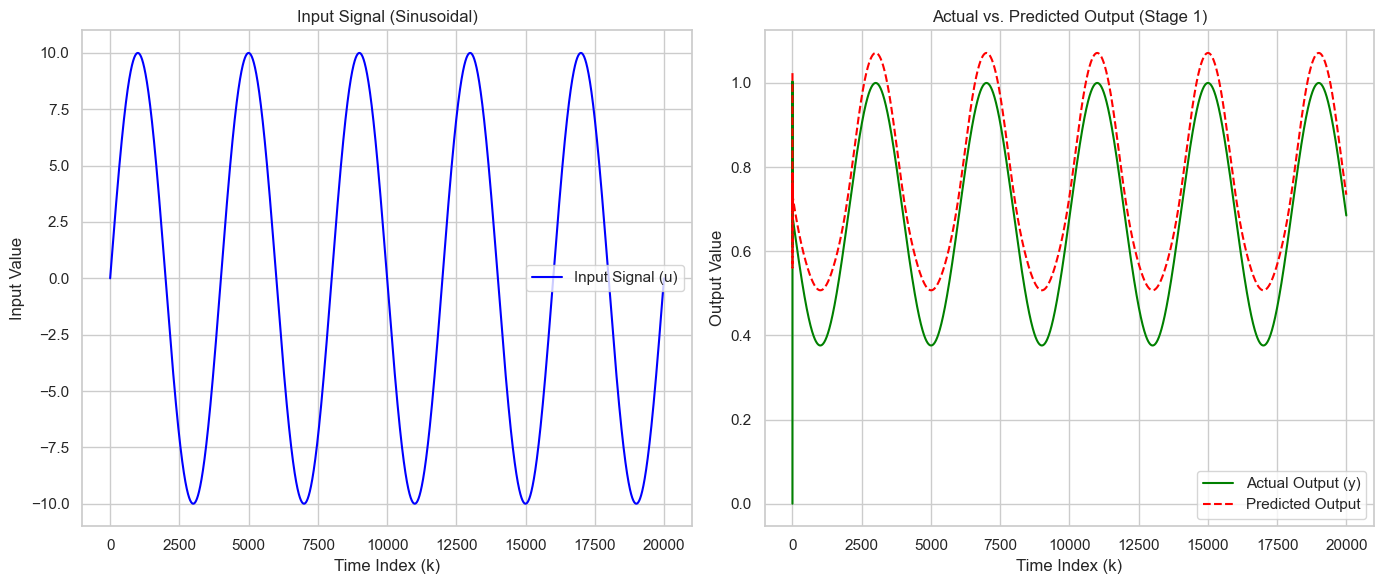

In [18]:
# Create a figure with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the input signal (u_test_sin) in the first subplot
sns.lineplot(x=range(len(u_test_sin)), y=u_test_sin, ax=ax[0], color='blue', label='Input Signal (u)')
ax[0].set_xlabel('Time Index (k)')
ax[0].set_ylabel('Input Value')
ax[0].set_title('Input Signal (Sinusoidal)')
ax[0].legend()

# Plot actual vs. predicted output (y_test_sin vs. y_pred_test_sin_t1) in the second subplot
sns.lineplot(x=range(len(y_test_sin)), y=y_test_sin, ax=ax[1], color='green', label='Actual Output (y)')
sns.lineplot(x=range(len(y_test_sin)), y=y_pred_test_sin_t1, ax=ax[1], color='red', linestyle='--', label='Predicted Output')
ax[1].set_xlabel('Time Index (k)')
ax[1].set_ylabel('Output Value')
ax[1].set_title('Actual vs. Predicted Output (Stage 1)')
ax[1].legend()

# Adjust the layout and show the plots
plt.tight_layout()
plt.show()

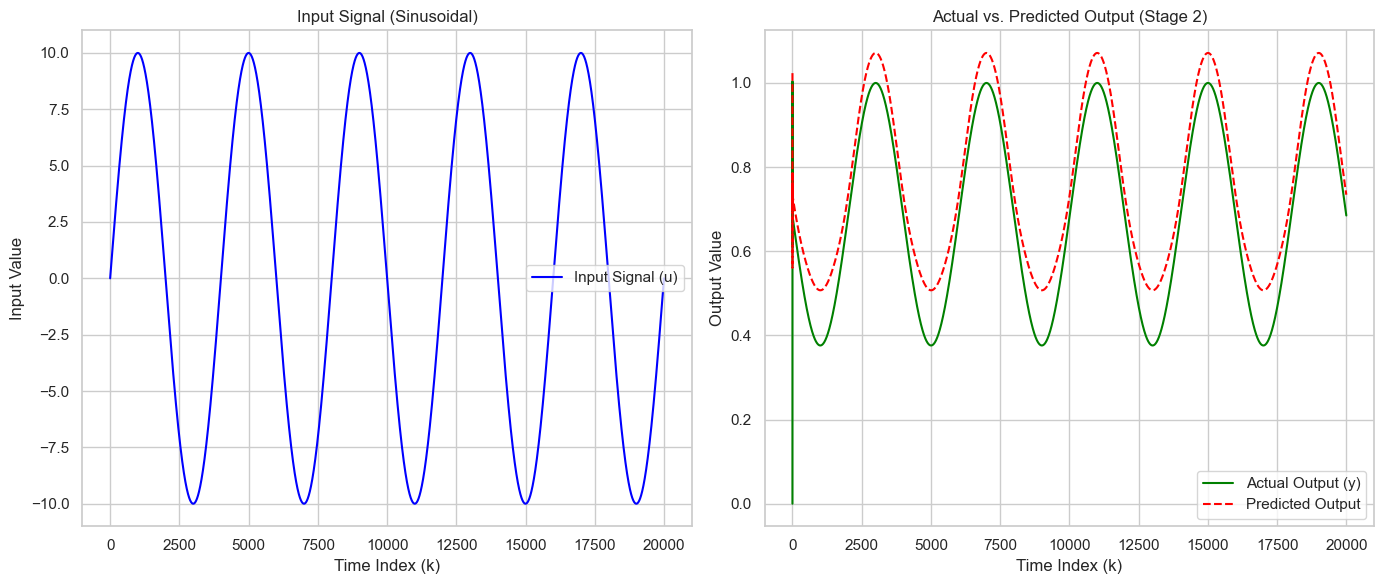

In [19]:
# Create a figure with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the input signal (u_test_sin) in the first subplot
sns.lineplot(x=range(len(u_test_sin)), y=u_test_sin, ax=ax[0], color='blue', label='Input Signal (u)')
ax[0].set_xlabel('Time Index (k)')
ax[0].set_ylabel('Input Value')
ax[0].set_title('Input Signal (Sinusoidal)')
ax[0].legend()

# Plot actual vs. predicted output (y_test_sin vs. y_pred_test_sin_t1) in the second subplot
sns.lineplot(x=range(len(y_test_sin)), y=y_test_sin, ax=ax[1], color='green', label='Actual Output (y)')
sns.lineplot(x=range(len(y_test_sin)), y=y_pred_test_sin_t2, ax=ax[1], color='red', linestyle='--', label='Predicted Output')
ax[1].set_xlabel('Time Index (k)')
ax[1].set_ylabel('Output Value')
ax[1].set_title('Actual vs. Predicted Output (Stage 2)')
ax[1].legend()

# Adjust the layout and show the plots
plt.tight_layout()
plt.show()

In [20]:
# Generate square wave input for u_test_square(k)
frequency = 2    # Frequency of the square wave
amplitude = 10   # Amplitude of the square wave
u_test_square = amplitude * signal.square(2 * np.pi * frequency * t_test)

# Initialize y_test_square(k) array and calculate values based on the given formula
y_test_square = np.zeros(k_max)
for k in range(1, k_max):
    y_test_square[k] = 1 / (1 + (y_test_square[k-1])**2) + 0.25 * u_test_square[k] - 0.3 * u_test_square[k-1]

# Shift arrays for y_test_square(k-1), y_test_square(k-2), u_test_square(k-1), u_test_square(k-2)
y_k_1_test_square = np.zeros(k_max)
y_k_2_test_square = np.zeros(k_max)
u_k_1_test_square = np.zeros(k_max)
u_k_2_test_square = np.zeros(k_max)

y_k_1_test_square[1:] = y_test_square[:-1]
y_k_2_test_square[2:] = y_test_square[:-2]
u_k_1_test_square[1:] = u_test_square[:-1]
u_k_2_test_square[2:] = u_test_square[:-2]

# Initialize MinMaxScaler to scale between -1 and 1
scaler_y = MinMaxScaler(feature_range=(-1, 1))
scaler_u = MinMaxScaler(feature_range=(-1, 1))

# Fit the scalers on training data (assuming y and u are defined)
scaler_y.fit(y.reshape(-1, 1))  # Fit on y
scaler_u.fit(u.reshape(-1, 1))  # Fit on u

# Normalize the testing data using the fitted scalers
y_test_square_norm = scaler_y.transform(y_test_square.reshape(-1, 1)).flatten()
y_k_1_test_square_norm = scaler_y.transform(y_k_1_test_square.reshape(-1, 1)).flatten()
y_k_2_test_square_norm = scaler_y.transform(y_k_2_test_square.reshape(-1, 1)).flatten()

u_test_square_norm = scaler_u.transform(u_test_square.reshape(-1, 1)).flatten()
u_k_1_test_square_norm = scaler_u.transform(u_k_1_test_square.reshape(-1, 1)).flatten()
u_k_2_test_square_norm = scaler_u.transform(u_k_2_test_square.reshape(-1, 1)).flatten()

# Prepare input matrices for the models
X_test_square_norm = np.array([y_k_1_test_square_norm, y_k_2_test_square_norm, u_test_square_norm, u_k_1_test_square_norm, u_k_2_test_square_norm]).T
X_test_square = np.array([y_k_1_test_square, y_k_2_test_square, u_test_square, u_k_1_test_square, u_k_2_test_square]).T

# Make predictions using the models
y_pred_test_square_t2 = nnv.predict(X_test_square).flatten()  # Predictions from model nnv
y_pred_test_square_t1 = nn.predict(X_test_square).flatten()   # Predictions from model nn

C:\Users\Acer\AppData\Local\Temp\ipykernel_13240\1528841553.py:226: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[k][0] = y_pred[-1]  # Feedback from the last prediction
C:\Users\Acer\AppData\Local\Temp\ipykernel_13240\1528841553.py:227: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[k][1] = y_pred_prev


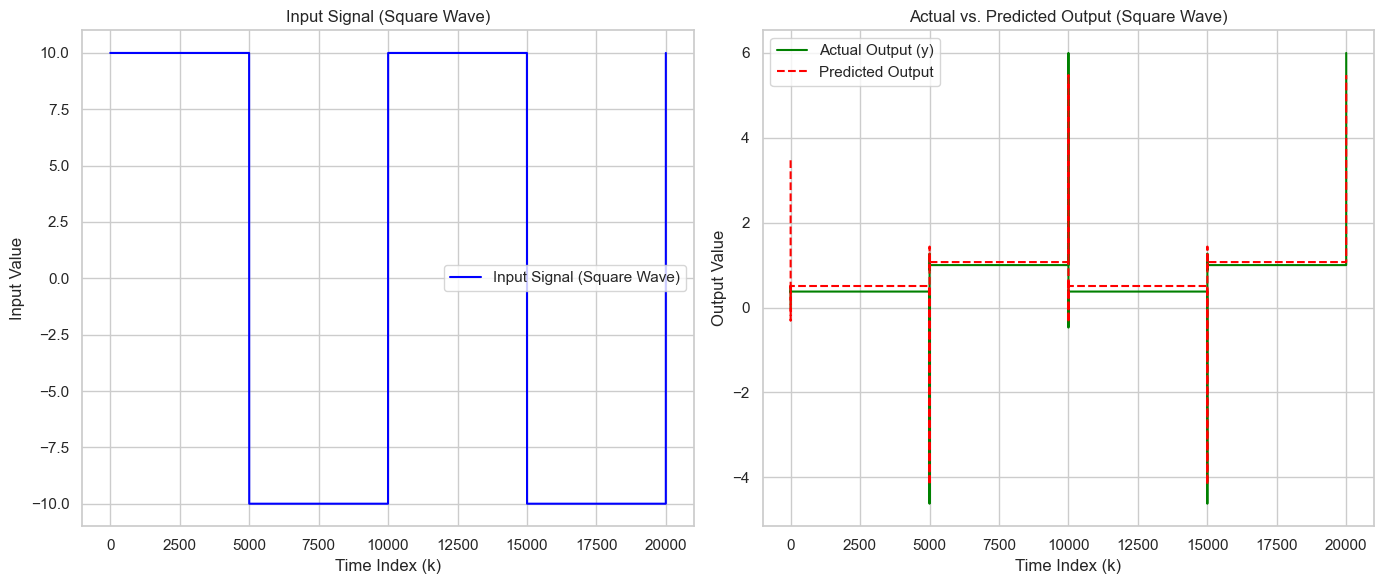

In [21]:
# Create a figure with 1 row and 2 columns to visualize square wave input and model output
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the input signal (u_test_square) in the first subplot
sns.lineplot(x=range(len(u_test_square)), y=u_test_square, ax=ax[0], color='blue', label='Input Signal (Square Wave)')
ax[0].set_xlabel('Time Index (k)')
ax[0].set_ylabel('Input Value')
ax[0].set_title('Input Signal (Square Wave)')
ax[0].legend()

# Plot actual vs. predicted output (y_test_square vs. y_pred_test_square_t1) in the second subplot
sns.lineplot(x=range(len(y_test_square)), y=y_test_square, ax=ax[1], color='green', label='Actual Output (y)')
sns.lineplot(x=range(len(y_test_square)), y=y_pred_test_square_t1, ax=ax[1], color='red', linestyle='--', label='Predicted Output')
ax[1].set_xlabel('Time Index (k)')
ax[1].set_ylabel('Output Value')
ax[1].set_title('Actual vs. Predicted Output (Square Wave)')
ax[1].legend()

# Adjust the layout and show the plots
plt.tight_layout()
plt.show()

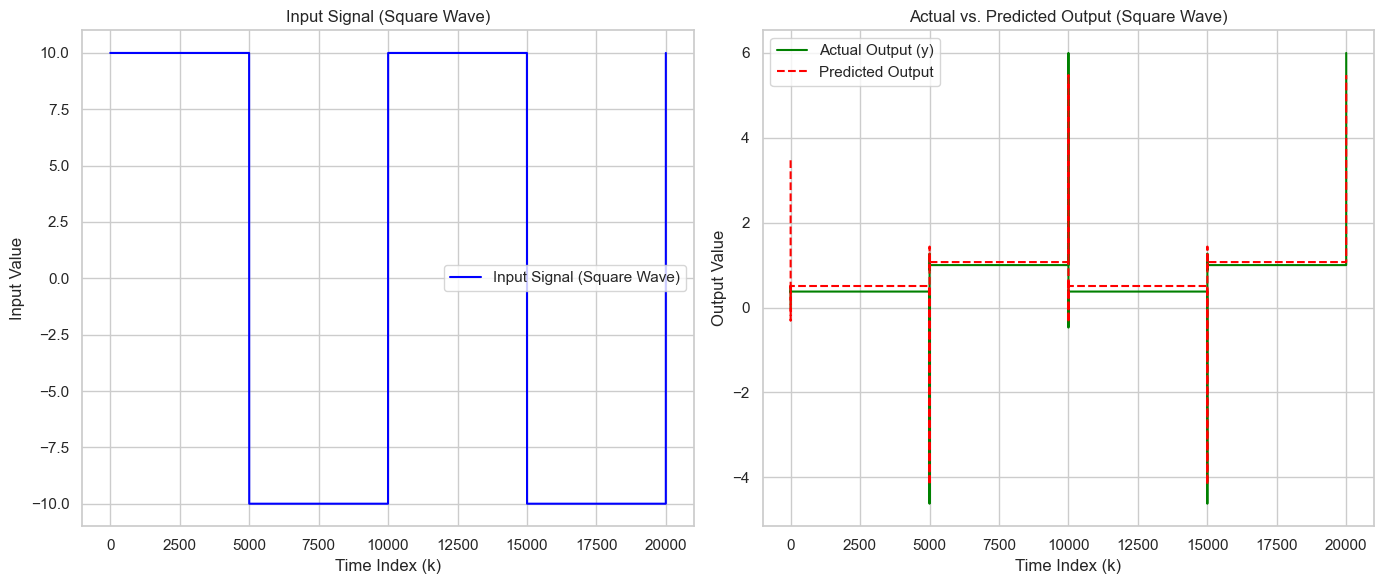

In [22]:
# Create a figure with 1 row and 2 columns to visualize square wave input and model output
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the input signal (u_test_square) in the first subplot
sns.lineplot(x=range(len(u_test_square)), y=u_test_square, ax=ax[0], color='blue', label='Input Signal (Square Wave)')
ax[0].set_xlabel('Time Index (k)')
ax[0].set_ylabel('Input Value')
ax[0].set_title('Input Signal (Square Wave)')
ax[0].legend()

# Plot actual vs. predicted output (y_test_square vs. y_pred_test_square_t1) in the second subplot
sns.lineplot(x=range(len(y_test_square)), y=y_test_square, ax=ax[1], color='green', label='Actual Output (y)')
sns.lineplot(x=range(len(y_test_square)), y=y_pred_test_square_t2, ax=ax[1], color='red', linestyle='--', label='Predicted Output')
ax[1].set_xlabel('Time Index (k)')
ax[1].set_ylabel('Output Value')
ax[1].set_title('Actual vs. Predicted Output (Square Wave)')
ax[1].legend()

# Adjust the layout and show the plots
plt.tight_layout()
plt.show()

In [23]:
# Generate triangle wave input for u_test_triangle(k)
frequency = 5    # Frequency of the triangle wave
amplitude = 10   # Amplitude of the triangle wave
u_test_triangle = amplitude * signal.sawtooth(2 * np.pi * frequency * t_test, 0.5)  # 0.5 duty cycle for a triangle wave

# Initialize y_test_triangle(k) array and calculate values based on the given formula
y_test_triangle = np.zeros(k_max)
for k in range(1, k_max):
    y_test_triangle[k] = 1 / (1 + (y_test_triangle[k-1])**2) + 0.25 * u_test_triangle[k] - 0.3 * u_test_triangle[k-1]

# Shift arrays for y_test_triangle(k-1), y_test_triangle(k-2), u_test_triangle(k-1), u_test_triangle(k-2)
y_k_1_test_triangle = np.zeros(k_max)
y_k_2_test_triangle = np.zeros(k_max)
u_k_1_test_triangle = np.zeros(k_max)
u_k_2_test_triangle = np.zeros(k_max)

y_k_1_test_triangle[1:] = y_test_triangle[:-1]
y_k_2_test_triangle[2:] = y_test_triangle[:-2]
u_k_1_test_triangle[1:] = u_test_triangle[:-1]
u_k_2_test_triangle[2:] = u_test_triangle[:-2]

# Initialize MinMaxScaler to scale between -1 and 1
scaler_y = MinMaxScaler(feature_range=(-1, 1))
scaler_u = MinMaxScaler(feature_range=(-1, 1))

# Fit the scalers on training data (assuming y and u are defined)
scaler_y.fit(y.reshape(-1, 1))  # Fit on y
scaler_u.fit(u.reshape(-1, 1))  # Fit on u

# Normalize the testing data using the fitted scalers
y_test_triangle_norm = scaler_y.transform(y_test_triangle.reshape(-1, 1)).flatten()
y_k_1_test_triangle_norm = scaler_y.transform(y_k_1_test_triangle.reshape(-1, 1)).flatten()
y_k_2_test_triangle_norm = scaler_y.transform(y_k_2_test_triangle.reshape(-1, 1)).flatten()

u_test_triangle_norm = scaler_u.transform(u_test_triangle.reshape(-1, 1)).flatten()
u_k_1_test_triangle_norm = scaler_u.transform(u_k_1_test_triangle.reshape(-1, 1)).flatten()
u_k_2_test_triangle_norm = scaler_u.transform(u_k_2_test_triangle.reshape(-1, 1)).flatten()

# Prepare input matrices for the models
X_test_triangle_norm = np.array([y_k_1_test_triangle_norm, y_k_2_test_triangle_norm, u_test_triangle_norm, u_k_1_test_triangle_norm, u_k_2_test_triangle_norm]).T
X_test_triangle = np.array([y_k_1_test_triangle, y_k_2_test_triangle, u_test_triangle, u_k_1_test_triangle, u_k_2_test_triangle]).T

# Make predictions using the models
y_pred_test_triangle_t2 = nnv.predict(X_test_triangle).flatten()  # Predictions from model nnv
y_pred_test_triangle_t1 = nn.predict(X_test_triangle).flatten()   # Predictions from model nn

C:\Users\Acer\AppData\Local\Temp\ipykernel_13240\1528841553.py:226: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[k][0] = y_pred[-1]  # Feedback from the last prediction
C:\Users\Acer\AppData\Local\Temp\ipykernel_13240\1528841553.py:227: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[k][1] = y_pred_prev


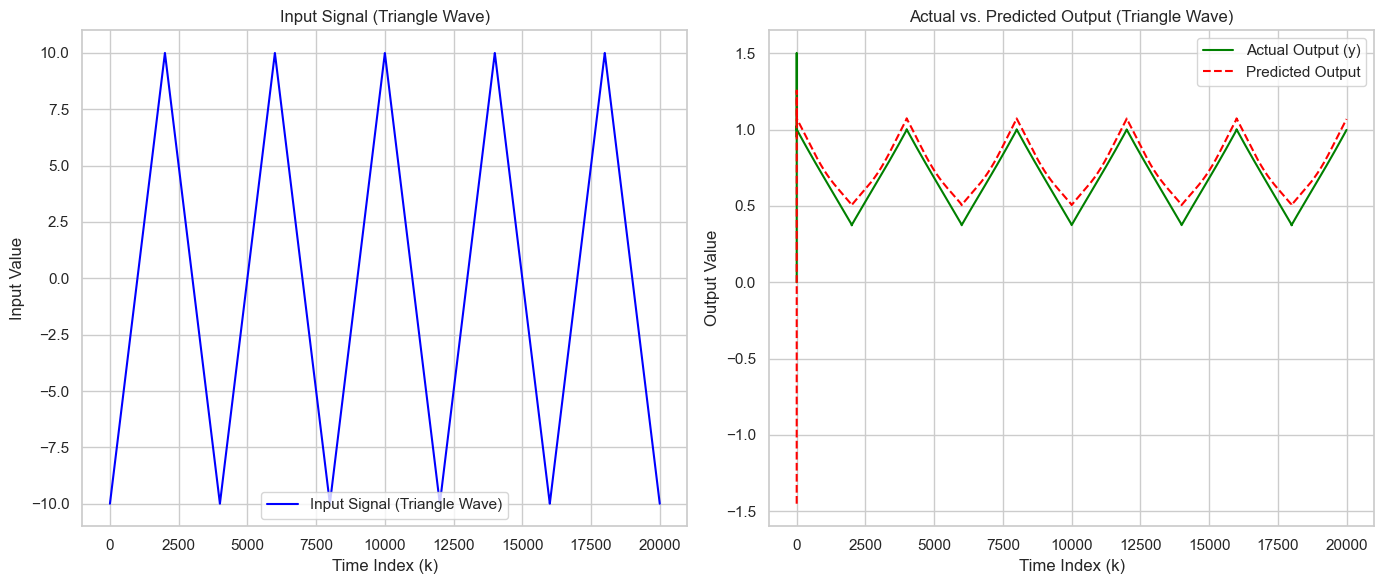

In [24]:
# Create a figure with 1 row and 2 columns to visualize triangle wave input and model output
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the input signal (u_test_triangle) in the first subplot
sns.lineplot(x=range(len(u_test_triangle)), y=u_test_triangle, ax=ax[0], color='blue', label='Input Signal (Triangle Wave)')
ax[0].set_xlabel('Time Index (k)')
ax[0].set_ylabel('Input Value')
ax[0].set_title('Input Signal (Triangle Wave)')
ax[0].legend()

# Plot actual vs. predicted output (y_test_triangle vs. y_pred_test_triangle_t1) in the second subplot
sns.lineplot(x=range(len(y_test_triangle)), y=y_test_triangle, ax=ax[1], color='green', label='Actual Output (y)')
sns.lineplot(x=range(len(y_test_triangle)), y=y_pred_test_triangle_t1, ax=ax[1], color='red', linestyle='--', label='Predicted Output')
ax[1].set_xlabel('Time Index (k)')
ax[1].set_ylabel('Output Value')
ax[1].set_title('Actual vs. Predicted Output (Triangle Wave)')
ax[1].legend()

# Adjust the layout and show the plots
plt.tight_layout()
plt.show()

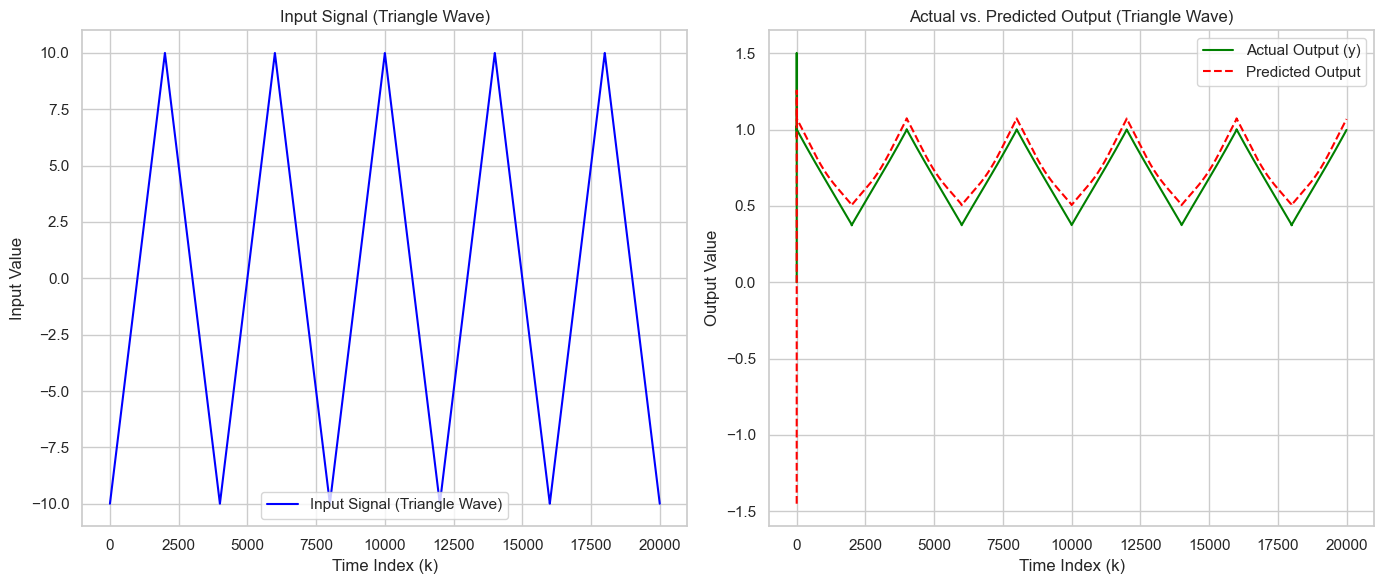

In [25]:
# Create a figure with 1 row and 2 columns to visualize triangle wave input and model output
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the input signal (u_test_triangle) in the first subplot
sns.lineplot(x=range(len(u_test_triangle)), y=u_test_triangle, ax=ax[0], color='blue', label='Input Signal (Triangle Wave)')
ax[0].set_xlabel('Time Index (k)')
ax[0].set_ylabel('Input Value')
ax[0].set_title('Input Signal (Triangle Wave)')
ax[0].legend()

# Plot actual vs. predicted output (y_test_triangle vs. y_pred_test_triangle_t1) in the second subplot
sns.lineplot(x=range(len(y_test_triangle)), y=y_test_triangle, ax=ax[1], color='green', label='Actual Output (y)')
sns.lineplot(x=range(len(y_test_triangle)), y=y_pred_test_triangle_t2, ax=ax[1], color='red', linestyle='--', label='Predicted Output')
ax[1].set_xlabel('Time Index (k)')
ax[1].set_ylabel('Output Value')
ax[1].set_title('Actual vs. Predicted Output (Triangle Wave)')
ax[1].legend()

# Adjust the layout and show the plots
plt.tight_layout()
plt.show()